In [1]:
from itertools import chain
from random import random

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

from society.action import Action
from society.agent import Agent
from society.simulations.adaptive import AdaptiveSimulation
from society.agents.constant import AllC, AllD
from society.agents.qlearning import TabularQLearner
from society.agents.random import Random
from society.agents.tft import TitForTat
from society.visualisation.network import *

plt.rcParams["figure.figsize"] = (10, 6)

In [2]:
def generate_population(communities, size):
    population = communities * size

    agents = [
        TabularQLearner(lookback=2, epsilon=0.1, learning_rate=0.05)
        for i in range(population)
    ]

    G = nx.connected_caveman_graph(communities, size)

    weights_matrix = np.zeros((population, population))
    for u, v, d in G.edges(data=True):
        weights_matrix[u, v] = weights_matrix[v, u] = 1
        try:
            d["weight"] = weights_matrix[u, v]
        except:
            d["weight"] = 0

    return agents, weights_matrix, G

In [3]:
# _, _, G = generate_population(1, 16)

# nx.draw(G, pos=nx.spring_layout(G), font_color="white", with_labels=True)

In [4]:
def compute_policies(agents):
    policies = [
        agent._q_table.argmax(axis=-1) if hasattr(agent, "_q_table") else None
        for agent in agents
    ]

    return [
        "".join(
            [
                ("C", "D")[policy[i, j]]
                for i in range(4)
                for j in range(4)
                # for k in range(4)
            ]
        )
        if policy is not None
        else "OTHER"
        for policy in policies
    ]


def calculate_cooperativeness(history):
    count = history.count(Action.COOPERATE)

    return count / len(history)

In [5]:
PAYOFF_LABELS = ["(C, C)", "(C, D)", "(D, C)", "(D, D)"]
# PAYOFF_LABELS = ["R", "S", "T", "P"]

Run 1:   0%|          | 0/20000 [00:00<?, ?it/s]

BEST AGENT: 139212 (0.6036658056824955, DDCCCCCCDCCCCCCC)
WORST AGENT: 109256 (0.9513890644354003, CCCCCCCCCCCDCCCC)


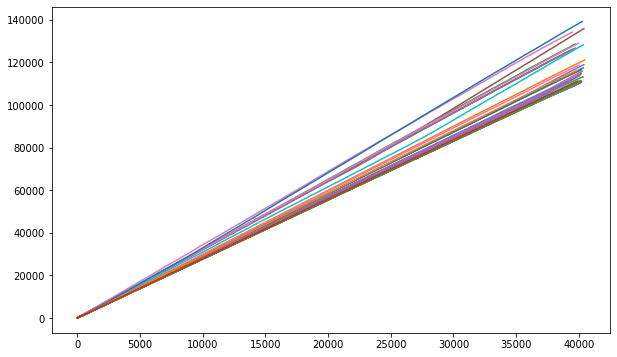

In [6]:
POPULATION = (1, 64)
ROUNDS = 20_000

run_rewards = []
run_cumulative_rewards = []
run_action_histories = []
run_reward_histories = []
run_policies = []

for run in range(1):
    # Generate a new population
    agents, weights_matrix, G = generate_population(*POPULATION)

    # Run a number of rounds
    sim = AdaptiveSimulation(agents, weights_matrix)

    # Run the simulation
    sim.reset()
    for i in tqdm(range(ROUNDS), desc=f"Run {run + 1}"):
        sim.play_round(train=True)

    # Store results
    run_rewards.append(sim.rewards)
    run_action_histories.append(sim.action_histories)
    run_reward_histories.append(sim.reward_histories)
    run_policies.append(compute_policies(agents))

    # Output statistics for the best and worst agents
    cumulative_rewards = [
        (i, sum(history)) for i, history in enumerate(sim.reward_histories)
    ]
    cumulative_rewards.sort(key=lambda x: x[1], reverse=True)

    # TODO: maybe I should switch to mean rewards (?)
    # mean_rewards = [(i, np.mean(history)) for i, history in enumerate(sim.reward_histories)]
    # mean_rewards.sort(key=lambda x: x[1], reverse=True)

    tqdm.write(
        f"BEST AGENT: {cumulative_rewards[0][1]} ({calculate_cooperativeness(list(chain(*sim.action_histories[cumulative_rewards[0][0]])))}, {run_policies[-1][cumulative_rewards[0][0]]})"
    )
    tqdm.write(
        f"WORST AGENT: {cumulative_rewards[-1][1]} ({calculate_cooperativeness(list(chain(*sim.action_histories[cumulative_rewards[-1][0]])))}, {run_policies[-1][cumulative_rewards[-1][0]]})"
    )

    for rh in sim.reward_histories:
        plt.plot(np.cumsum(rh))

    plt.show()

In [7]:
sim.calculate_weights()

[[1.06,
  1.04,
  1.02,
  1.06,
  1.04,
  1.06,
  1.04,
  1.0,
  1.06,
  1.08,
  1.04,
  1.06,
  1.06,
  1.04,
  1.06,
  1.08,
  1.06,
  1.04,
  0.98,
  1.06,
  1.06,
  1.06,
  1.04,
  1.0,
  1.06,
  1.08,
  1.04,
  1.0,
  1.04,
  1.06,
  1.06,
  1.08,
  1.02,
  1.02,
  1.08,
  1.08,
  1.06,
  1.02,
  1.02,
  1.06,
  1.04,
  1.06,
  1.04,
  1.04,
  1.08,
  1.04,
  1.08,
  1.0,
  1.06,
  1.06,
  1.06,
  1.06,
  1.02,
  1.1,
  1.08,
  1.04,
  1.08,
  1.1,
  1.06,
  1.04,
  1.06,
  1.0],
 [0.7599999999999999,
  0.7599999999999999,
  0.7799999999999999,
  0.82,
  0.7799999999999999,
  0.7599999999999999,
  0.74,
  0.9,
  0.72,
  0.74,
  0.84,
  0.7999999999999999,
  0.82,
  0.72,
  0.74,
  0.82,
  0.7599999999999999,
  0.82,
  0.7999999999999999,
  0.7599999999999999,
  0.7799999999999999,
  0.74,
  0.74,
  1.0,
  0.7599999999999999,
  0.7999999999999999,
  0.7599999999999999,
  0.7599999999999999,
  0.7999999999999999,
  0.7999999999999999,
  0.82,
  0.84,
  0.7,
  0.7599999999999999,
  0

In [8]:
sim.action_histories[0][2]

[<Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>

In [9]:
cumulative_rewards[0][0]

60

In [10]:
agents[cumulative_rewards[0][0]]._q_table

array([[[259.40881801, 275.90718249],
        [142.9185164 , 262.51823238],
        [280.37740094, 274.10950908],
        [273.00669919, 202.31468788]],

       [[271.77398803, 241.37726656],
        [265.9721442 ,  63.76763722],
        [273.85215628, 111.96299571],
        [230.5867689 ,  35.94119897]],

       [[273.98412496, 282.09803999],
        [270.73549943, 220.50377316],
        [278.97347276, 151.7298879 ],
        [226.39041525,  40.44809895]],

       [[275.10885453, 243.56039262],
        [257.62857169,  38.72670065],
        [249.86436422,  96.73701983],
        [  8.16474958,   5.46725604]]])

In [11]:
# from datetime import datetime
# import pickle

# with open(f"results - {datetime.isoformat(datetime.now()).replace(':', '-')}.pickle", "wb") as f:
#     pickle.dump({
#         "rewards": run_rewards,
#         "cumulative_rewards": run_cumulative_rewards,
#         # "action_histories": run_action_histories,
#         "reward_histories": run_reward_histories,
#         "policies": run_policies,
#     }, f)

In [12]:
cumulative_reward_policy_ranks = {}
cumulative_reward_policies = {}

for policies, reward_histories in zip(run_policies, run_reward_histories):
    cumulative_rewards = [
        (i, sum(history)) for i, history in enumerate(reward_histories)
    ]
    cumulative_rewards.sort(key=lambda x: x[1], reverse=True)

    for rank, (i, cumulative_reward) in enumerate(cumulative_rewards):
        policy = policies[i]

        if policy not in cumulative_reward_policy_ranks:
            cumulative_reward_policy_ranks[policy] = []
            cumulative_reward_policies[policy] = []

        cumulative_reward_policy_ranks[policy].append(rank + 1)
        cumulative_reward_policies[policy].append(cumulative_reward)

mean_cumulative_reward_policy_ranks = {
    policy: np.mean(ranks) for policy, ranks in cumulative_reward_policy_ranks.items()
}
mean_cumulative_reward_policies = {
    policy: np.mean(rewards) for policy, rewards in cumulative_reward_policies.items()
}

In [13]:
for policy in sorted(
    mean_cumulative_reward_policy_ranks,
    key=lambda x: mean_cumulative_reward_policy_ranks[x],
):
    print(f"{mean_cumulative_reward_policy_ranks[policy]:<24} {policy}")

1.0                      DDCCCCCCDCCCCCCC
2.0                      DCCDCCCCDCCCCCCC
4.0                      DCCCCDCCCCCCCCDC
5.0                      DCCCCCCCDCCCDCCC
6.0                      DCCCCCDCDCCCCCCC
11.0                     CDCCCCDCCCCCCCDC
13.0                     DCCCDCCCCCCCCCCC
13.0                     CDDCCCCCCDCDCDCC
15.5                     CDCCCCCCCCCCCCCC
17.0                     CCCCDCCCCDCCCCCC
17.5                     DCDCCCCCCCCCCCCC
18.0                     CDCDCCCCCDCCCCCC
19.0                     DCDCCCCCCCCCCCDC
21.0                     DCDCCCCCCCCCCCCD
22.0                     DCDCCCCCCCCCDCCD
25.0                     CCCCCDCCCCCCCCCC
25.77777777777778        DCCCCCCCCCCCCCCC
28.0                     CCCCCCCCCDCCDCCC
29.5                     CCCCCDCDCCCCCCCC
30.0                     CCCCCCCCCCCCDCCC
35.0                     CCCDCCCCCDCCCCCD
40.0                     CCCDCCCDCCCCCCDC
40.5                     CCCCCCCDCCCCCCCC
41.0                     CCCCCCCDC

In [14]:
for policy in sorted(
    mean_cumulative_reward_policies,
    key=lambda x: mean_cumulative_reward_policies[x],
    reverse=True,
):
    print(f"{mean_cumulative_reward_policies[policy]:<24} {policy}")

139212.0                 DDCCCCCCDCCCCCCC
135826.0                 DCCDCCCCDCCCCCCC
129012.0                 DCCCCDCCCCCCCCDC
128658.0                 DCCCCCCCDCCCDCCC
128240.0                 DCCCCCDCDCCCCCCC
121153.0                 CDCCCCDCCCCCCCDC
119188.0                 DCDCCCCCCCCCCCCC
118724.0                 CDDCCCCCCDCDCDCC
118186.0                 DCCCDCCCCCCCCCCC
117673.77777777778       DCCCCCCCCCCCCCCC
116596.5                 CDCCCCCCCCCCCCCC
116400.0                 CCCCDCCCCDCCCCCC
116167.0                 CDCDCCCCCDCCCCCC
115809.0                 DCDCCCCCCCCCCCDC
114655.0                 DCDCCCCCCCCCCCCD
114458.0                 DCDCCCCCCCCCDCCD
113230.0                 CCCCCDCCCCCCCCCC
111162.0                 CCCCCCCCCDCCDCCC
111158.0                 CCCCCDCDCCCCCCCC
111105.0                 CCCCCCCCCCCCDCCC
110996.0                 CCCDCCCCCDCCCCCD
110710.0                 CCCCCCCDCCCCCCCC
110686.0                 CCCDCCCDCCCCCCDC
110643.0                 CCCCCCCDC

In [15]:
compute_policies([agents[cumulative_rewards[0][0]]])

['DDCCCCCCDCCCCCCC']

In [16]:
agents[cumulative_rewards[0][0]]._q_table

array([[[259.40881801, 275.90718249],
        [142.9185164 , 262.51823238],
        [280.37740094, 274.10950908],
        [273.00669919, 202.31468788]],

       [[271.77398803, 241.37726656],
        [265.9721442 ,  63.76763722],
        [273.85215628, 111.96299571],
        [230.5867689 ,  35.94119897]],

       [[273.98412496, 282.09803999],
        [270.73549943, 220.50377316],
        [278.97347276, 151.7298879 ],
        [226.39041525,  40.44809895]],

       [[275.10885453, 243.56039262],
        [257.62857169,  38.72670065],
        [249.86436422,  96.73701983],
        [  8.16474958,   5.46725604]]])

In [17]:
from itertools import product

P = compute_policies([agents[cumulative_rewards[0][0]]])[0]

for m, p in zip(product(PAYOFF_LABELS, PAYOFF_LABELS), P):
    print(m, "=>", p)

('(C, C)', '(C, C)') => D
('(C, C)', '(C, D)') => D
('(C, C)', '(D, C)') => C
('(C, C)', '(D, D)') => C
('(C, D)', '(C, C)') => C
('(C, D)', '(C, D)') => C
('(C, D)', '(D, C)') => C
('(C, D)', '(D, D)') => C
('(D, C)', '(C, C)') => D
('(D, C)', '(C, D)') => C
('(D, C)', '(D, C)') => C
('(D, C)', '(D, D)') => C
('(D, D)', '(C, C)') => C
('(D, D)', '(C, D)') => C
('(D, D)', '(D, C)') => C
('(D, D)', '(D, D)') => C
